In [6]:
import pandas as pd
import keras as keras
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
import glob
import numpy as np
import matplotlib.pyplot as plt
import csv
!pip install python_speech_features


  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5870 sha256=fb452ae2d80448f18a20cb1f04ac2c17fb51ce0d27dba4677dfa35430f27bf48
  Stored in directory: /root/.cache/pip/wheels/5a/9e/68/30bad9462b3926c29e315df16b562216d12bdc215f4d240294
Successfully built python_speech_features


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# !cd '/content/drive/MyDrive/OKN/Master IA/Master IA/TFM/mindwave/FASE3' && pwd
# prefix= '/drive/MyDrive/OKN/Master IA/Master IA/TFM/mindwave/FASE3'


Mounted at /content/drive
/content/drive/MyDrive/OKN/Master IA/Master IA/TFM/mindwave/FASE3


In [2]:
import glob
!git clone https://github.com/javierrca/eegcom.git


Cloning into 'eegcom'...
remote: Enumerating objects: 1666, done.
remote: Counting objects: 100% (1666/1666), done.
remote: Compressing objects: 100% (1549/1549), done.
remote: Total 1666 (delta 87), reused 1658 (delta 82), pack-reused 0
Receiving objects: 100% (1666/1666), 14.12 MiB | 7.47 MiB/s, done.
Resolving deltas: 100% (87/87), done.
Filtering content: 100% (11/11), 1.40 GiB | 48.00 MiB/s, done.


In [3]:
ds_path = "/content/eegcom/dataset"
person_code = "01"
base_path = ds_path + "/" + person_code
print('\nNamed with wildcard *:')
paths=[]
for name in glob.glob(base_path+'/*',recursive = True):
  paths.append(name+"/")

print(paths)

!cd paths[0] && ls -l


Named with wildcard *:
['/content/eegcom/dataset/01/ses12/', '/content/eegcom/dataset/01/ses21/', '/content/eegcom/dataset/01/ses05/', '/content/eegcom/dataset/01/ses20/', '/content/eegcom/dataset/01/ses13/', '/content/eegcom/dataset/01/ses01/', '/content/eegcom/dataset/01/ses10/', '/content/eegcom/dataset/01/ses22/', '/content/eegcom/dataset/01/ses14/', '/content/eegcom/dataset/01/ses15/', '/content/eegcom/dataset/01/ses08/', '/content/eegcom/dataset/01/ses03/', '/content/eegcom/dataset/01/ses02/', '/content/eegcom/dataset/01/ses17/', '/content/eegcom/dataset/01/ses18/', '/content/eegcom/dataset/01/ses04/', '/content/eegcom/dataset/01/ses11/', '/content/eegcom/dataset/01/ses16/', '/content/eegcom/dataset/01/ses07/', '/content/eegcom/dataset/01/ses19/', '/content/eegcom/dataset/01/ses06/', '/content/eegcom/dataset/01/ses23/', '/content/eegcom/dataset/01/ses09/']
/bin/bash: line 1: cd: paths[0]: No such file or directory


# Dataset RAW

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def getRaw(paths):
    dfRaw = []
    X_raw_train = []
    y_raw_train =[]
    filter=[]
    filterLastRows = 1000

    i=0
    # print (paths)
    for path in paths:
        dfHead = pd.read_csv(path + 'head.csv')
        all_raw_files = glob.glob(os.path.join(path , "*RAW*.csv"))

        for filename in all_raw_files:
            dfRaw = pd.read_csv(filename, index_col=None, header=0)
            if len(dfRaw)>filterLastRows:
                qCode = dfRaw['questionCode'].iloc[[0]][0]
                X = np.array(dfRaw.tail(filterLastRows)['rawEeg'])
                samples = list()
                length = 1000
                for j in range(0,filterLastRows,length):
                    sample = X[j:j+length]
                    samples.append(sample)

                for ids, X in enumerate(samples):
                    X_raw_train.append([])
                    for idx, it in enumerate(X):
                        X_raw_train[i].append([])
                        X_raw_train[i][idx].append([])
                        X_raw_train[i][idx][0] = X[idx]
                    y_raw_train.append([])
                    y_raw_train[i].append([])
                    y_raw_train[i][0] = dfHead[dfHead['questionCode']==qCode].iloc[0]['response']
                    i=i+1

    return X_raw_train,y_raw_train



def get_accuraccy(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test,pred_y)
    a = conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[0][1])
    b = conf_matrix[1][1] / (conf_matrix[1][0] + conf_matrix[1][1])
    acc = (a + b)/2
    print ("calc accuracy : " + str(acc))
    return acc

def show_results(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test,pred_y)
    plt.figure(figsize=(2,2))
    labels = ['0: No', '1: Si']
    sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt='d')
    plt.title('Confusion matrix')
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print(conf_matrix)
    print(classification_report(y_test,pred_y))
    return

X_raw_train = []
y_raw_train =[]
X_raw_train,y_raw_train= getRaw(paths)
X = np.array(X_raw_train)
y = np.array(y_raw_train)
X.shape, y.shape


((225, 1000, 1), (225, 1))

In [11]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.25) # 0.25 x 0.8 = 0.2


y_val_cat =keras.utils.to_categorical(y_val,2)
y_train_cat =keras.utils.to_categorical(y_train,2)
y_test_cat =keras.utils.to_categorical(y_test,2)

X_train.shape, y_train.shape,X_test.shape,y_test.shape,X_val.shape, y_val.shape


((135, 1000, 1), (135, 1), (45, 1000, 1), (45, 1), (45, 1000, 1), (45, 1))

# Modelo RAW/LSTM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000, 64)          16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                        

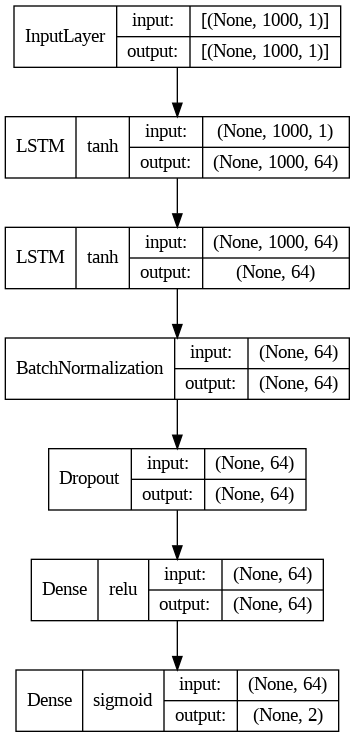

In [13]:
#Modelo raw.lstm
from keras.layers import Conv2D, LeakyReLU
from keras.utils import plot_model

keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model = keras.Sequential()
input_shape=(X_train.shape[1],X_train.shape[2])

model.add(LSTM(64, return_sequences=True,input_shape=input_shape))
model.add(LSTM(64))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(Dense(64, activation='relu'))

model.add(Dense(2, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
plot_model(model, 'net.png', show_shapes=True,show_layer_names=False,show_layer_activations=True)


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')> 0.56 and logs.get('accuracy')> 0.6):
              print("\nAlcanzado el 85% de precisión, se cancela el entrenamiento!!")
              self.model.stop_training = True
callbacks1 =myCallback()

j=0
acc=0
while j<10 and acc<0.52:
    j=j+1
    history = model.fit(X_train, y_train_cat, epochs=20, validation_data=(X_val, y_val_cat), verbose=1, callbacks=[callbacks1])
    # y_pred2 = [np.argmax(i) for i in model.predict(X_val)]
    # show_results(y_val,y_pred2)
    y_test_pred2 = [np.argmax(i) for i in model.predict(X_test)]
    acc = get_accuraccy(y_test,y_test_pred2)

show_results(y_test,y_test_pred2)